# Reads

In [ ]:
https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right

a figura com drvs justifica muito bem a escolha de 80% para teste


fazer eval em todos dfs de 80%, adicionar epoch e indices etc para depois pegar caso necessario
pegar melhor modelo olhando o loss e aplicar pra todos circuitos de teste fcn, ou fcn_large



Figura:
como alguem faria para usar o preditor
como alguem faria para testar com outra tecnologia o preditor
explicar que ele he independente de tecnologia
fluxograma mostrando a parte do ORDF e a parte do INNOVUS para geracao dos benchamrks
dps para geracao dos dados de treino e inferencia.
Explicar o problema dos dados, não é só uma questão de armazenamento, mas a leitura deles
tbm seria muito demorada inviabilizando o treino do modelo.
justificar o porque de pegar soh short

# Imports

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import shutil
import os
import time
import re
import subprocess
from sklearn.metrics import confusion_matrix
import gc

In [2]:
# FCN0 = [[('bp_multi', 82), ('swerv', 84), ('bp_multi', 87), ('bp_multi', 86)],
# FCN1 = [('aes', 88), ('bp_be', 77), ('bp_be', 76), ('bp_multi', 85)],
# FCN2 = [('aes', 76), ('aes', 80), ('aes', 73), ('bp_multi', 90)],
# FCN3 = [('aes', 87), ('bp_multi', 84), ('ibex', 90), ('aes', 89)],
# FCN4 = [('tinyRocket', 90), ('swerv', 82), ('bp_be', 80), ('bp_be', 75)]]

def getMetrics(tp, tn, fp, fn):
  specificity = tn/(fp+tn) # True Negative Rate (TNR), is also known as Specificity or Selectivity.
  sensitivity = tp/(tp+fn) # True Positive Rate (TPR), also known as Sensitivity, Recall, or the Hit Rate
  prevalence = ((tp+fn)/(tp+fn+fp+tn))
  accuracy = (tp+tn)/(tp+tn+fp+fn)
  # npv = tn/(fn+tn) # Negative Predictive Value (NPV)
  # fpr = fp/(tn+fp) # False Positive Rate (FPR), also known as the Fall-Out or Type I Error Rate or False Alarm Rate
  # fnr = fn / (fn + tp)# False Negative Rate (FNR), It's also known as the Miss Rate or Type II Error Rate.

  sqrt = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
  mcc = 0
  if sqrt != 0:
    mcc = ((tp * tn) - (fp * fn))/sqrt

  precision = tp/(tp + fp)# Positive Predictive Value (PPV), also known as Precision.
  beta=10
  fbeta = ((1 + pow(beta, 2)) * precision * sensitivity) / (pow(beta, 2) * precision + sensitivity)
  f1score = (2 * (precision * sensitivity)) / (precision + sensitivity)
  return {'tp':tp, 'tn':tn, 'fp':fp, 'fn':fn,
          'prevalence':prevalence,
          'specificity':specificity,
          'sensitivity':sensitivity,
          'precision':precision,
          'gmean':math.sqrt(sensitivity * specificity),
          'f1score':f1score,
          'fscore':fbeta,
          'accuracy':accuracy,
          'mcc':mcc}

In [ ]:
# ICECS work
tp=531234
fp=10892
tn=868532
fn=38998
getMetrics(tp, tn, fp, fn)

# Cross Validation Result

In [ ]:
crossValPath = '/home/sheiny/workspace/Predictor/results/FCNCV/'
# crossValPath = '/home/sheiny/workspace/Predictor/results/FCNModel10CV/'
pkls = [crossValPath+x for x in os.listdir(crossValPath) if ('.pkl' in x and 'CV' in x)]
pkls.sort(key=lambda x:int(re.search(r"\d+(\.\d+)?", x[x.rfind('/'):]).group(0)))

cvDicts = []
for group in range(len(pkls)):
  df = pickle.load(open(pkls[group], 'rb'))
  runs = {(row['Design'], row['Density']) for index, row in df.iterrows()}
  for run in runs:
    tempDf = df.loc[(df['Design'] == run[0]) & (df['Density'] == run[1])]
    metrics = getMetrics(sum(tempDf['tp']), sum(tempDf['tn']), sum(tempDf['fp']), sum(tempDf['fn']))
    cvDicts.append({'Group':str(int(group)),
                    'Design':run[0]+' '+str(run[1]),
                    'TP':metrics['tp'],
                    'TN':metrics['tn'],
                    'FP':metrics['fp'],
                    'FN':metrics['fn'],
                    'Prevalence %':metrics['prevalence']*100,
                    'Specificity %':metrics['specificity']*100,
                    'Sensitivity %':metrics['sensitivity']*100,
                    'G-Mean %':math.sqrt(metrics['sensitivity'] * metrics['specificity'])*100,
                    # 'f1-score':metrics['f1score'],
                    'F$_\beta$-score*':metrics['fscore'],
                    # 'precision':metrics['precision'],
                    'Accuracy %':metrics['accuracy']*100,
                    'MCC [-1:1]':metrics['mcc']})
cvDf = pd.DataFrame.from_dict(cvDicts)
# cvDf.loc['mean'] = cvDf.mean(numeric_only=True)
cvDf
# cvDf.to_csv('results/CrossValidation.csv', index=False)

In [ ]:
# CV cross-validation Confusion Matrix
tp = int(sum(cvDf['TP']))
tn = int(sum(cvDf['TN']))
fp = int(sum(cvDf['FP']))
fn = int(sum(cvDf['FN']))

cm = np.array([[tn, fp],
               [fn, tp]])

# Define class labels (binary classification)
class_labels = ['Negative', 'Positive']

# Create a figure and axis for the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Show all ticks and label them with their respective class names
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_labels, yticklabels=class_labels,
       title='5-Fold Cross-Validation Confusion Matrix',
       ylabel='True Label',
       xlabel='Predicted Label')

# Add color bar
plt.colorbar(im)

# Annotate the confusion matrix cells with the respective counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Display the plot
plt.show()
# plt.savefig('ConfusionMatrix.pdf')

# Prediction Results

In [ ]:
pkl = '/home/sheiny/workspace/Predictor/results/PredictionExperiment/predictRuns.pkl'
df = pickle.load(open(pkl, 'rb'))

circuitResultDict = []
runs = {(row['Design'], row['Density']) for index, row in df.iterrows()}
for run in runs:
  tempDf = df.loc[(df['Design'] == run[0]) & (df['Density'] == run[1])]
  metrics = getMetrics(sum(tempDf['tp']), sum(tempDf['tn']), sum(tempDf['fp']), sum(tempDf['fn']))
  tpr = metrics['tp']/(metrics['tp']+metrics['fn'])

  PosRatio = ((metrics['tp']+metrics['fn'])/(metrics['tp']+metrics['fn']+metrics['fp']+metrics['fn']))*100
  circuitResultDict.append({'Design':run[0]+str(run[1]),
                            'tp':str(metrics['tp'])+' ('+str(int(tpr*100))+'%)', 'tn':int(metrics['tn']),
                            'fp':int(metrics['fp']), 'fn':int(metrics['fn']),
                            'PosRatio%':PosRatio,
                            'spc %':metrics['specificity']*100, 'acc %':metrics['accuracy']*100, 'MCC[-1:1]':metrics['mcc']})
resultDf = pd.DataFrame.from_dict(circuitResultDict)
resultDf.set_index('Design', inplace=True)
resultDf.to_csv('results/predictionResult.csv')

# Plot DRVs and Predictions

In [ ]:
# design = '/home/sheiny/workspace/data/WholeCSV/aes'
# design = '/home/sheiny/workspace/data/WholeCSV/bp_be/'
# design = '/home/sheiny/workspace/data/bp_be/'
design = '/home/sheiny/workspace/data/WholeCSV/tinyRocket/'
# design = '/home/sheiny/workspace/data/WholeCSV/tinyRocket/'
# modelPath = 'results/fcn4/model_14.pkl'
# modelPath = 'results/cnn4/model_13.pkl'
targetDensity = '90'

modelPath = 'results/fcnNoAugment4/model_14.pkl'
# outPath = 'predictionscnn/aes88_'



def writePredictionFile(outFile, nodesToWrite):
  with open(outFile, 'w') as fp:
    for node in nodesToWrite:
      fp.write(str(node)+'\n')
  fp.close()

def predict(model, pkl):
  testDf = pd.read_pickle(pkl, compression='zip')
  labels = testDf.pop(testDf.columns.values[-1])
  nodeIDs = testDf.pop(testDf.columns.values[0])#drop first column which contains the nodeIds
  testHyperImages = np.array(testDf).reshape(len(testDf),22,33,33)
  predictions = model.predict(testHyperImages)
  del testDf
  gc.collect()
  return nodeIDs, predictions, labels

model = pickle.load(open(modelPath, 'rb'))
# pkls = [design+x for x in os.listdir(design) if '.pkl' in x]
pkls = [design+x for x in os.listdir(design) if '.pkl' in x and targetDensity in x]
pkls.sort(key = lambda x : int(x[x.rfind('_')+1:x.find('.')]))
results = []
for x in range(len(pkls)):
  print('Running:', x, ' out of ', len(pkls)-1)
  results.append(predict(model, pkls[x]))

tp = []
tn = []
fp = []
fn = []
for x, y, z in results:
  nodeIDs = [int(n) for n in x]
  predictions = y > 0.5
  for id, prediction, actual in zip(nodeIDs, predictions, z):
    if prediction == actual and actual == True:
      tp.append(id)
    elif prediction == actual and actual == False:
      tn.append(id)
    elif prediction != actual and actual == True:
      fn.append(id)
    else:
      fp.append(id)

# writePredictionFile(outPath+'tp.txt', tp)
# writePredictionFile(outPath+'tn.txt', tn)
# writePredictionFile(outPath+'fp.txt', fp)
# writePredictionFile(outPath+'fn.txt', fn)

In [ ]:
getMetrics(len(tp), len(tn), len(fp), len(fn))

In [ ]:
print('tp', len(tp), 'tn', len(tn), 'fp', len(fp), 'fn', len(fn))

# Threshold

In [ ]:
y_scores = [r[0] for r in results[0][1]]
for r in results[1][1]:
  y_scores.append(r[0])
y_true = [r for r in results[0][2]]
for r in results[1][2]:
  y_true.append(r)

prediction = [int(p > 0.5) for p in y_scores]

In [ ]:
# Convert lists to NumPy arrays
array1 = np.array(y_scores)
array2 = np.array(y_true)
array3 = np.array(prediction)

# Horizontal concatenate the arrays
out = np.hstack((array1[:, np.newaxis], array2[:, np.newaxis], array3[:, np.newaxis]))

In [ ]:
out.shape

In [ ]:
print(out[0])

In [ ]:
# Use numpy.savetxt() to save the ndarray to a CSV file
np.savetxt('threshold.csv', out, header=','.join(['Threshold', 'ActualLabel', 'ClassifiedLabel']), delimiter=',')

# Roc Curve for Aes88

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
y_scores = np.concatenate((results[0][1], results[1][1]))
y_true = np.concatenate((results[0][2], results[1][2]))

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
print("AUC-ROC:", roc_auc)

In [ ]:
# Plot the ROC curve
# design = 'TinyRocket90'
design = 'Swerv82'
model = 'fcnNoAugment4'

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic(ROC) Curve for '+design)
plt.legend(loc='lower right')
# plt.show()
plt.savefig('predictions/NewROC_'+model+'_'+design+'.pdf')

# Load BenchmarkInfo

In [3]:
csvPath = '/home/sheiny/workspace/data/CSVS/'
df = pd.read_pickle('benchmarkInfo/ufscbenchmark.pkl', compression='zip')
df = df.loc[df['Design'] != 'bp']
df = df.loc[df['Design'] != 'gcd']

df = df.loc[df['FDRVTotal'] == 0]
df.reset_index(inplace=True, drop=True)
inexistingFiles = []
for index in range(len(df)):
  design = df['Design'][index]
  density = df['Density'][index]
  if os.path.exists(csvPath+design+'/cts_'+design+'_'+str(density)+'.pkl') == False:
    inexistingFiles.append(index)
df.drop(inexistingFiles, inplace=True)
df.reset_index(inplace=True, drop=True)
df.sort_values('IDRVShort', ascending=False, inplace=True, ignore_index=True)

# Peason Correlation Analysis

In [ ]:
def CalculatePearsonCorrelation(df, xlabel, ylabel):
  # Calculate Pearson correlatioDRVsn coefficient
  correlation = df[xlabel].corr(df[ylabel])
  print(f"Pearson Correlation Coefficient: {correlation}")
  # Interpretation
  if abs(correlation) < 0.1:
    print("There is a very weak or no correlation between the two classes.")
  elif abs(correlation) < 0.3:
    print("There is a weak correlation between the two classes.")
  elif abs(correlation) < 0.5:
    print("There is a moderate correlation between the two classes.")
  else:
    print("There is a strong correlation between the two classes.")
  return correlation

def ScatterPlot(df, x, xlabel, xlegend, y, ylabel, ylegend, correlation, xlog=False, ylog=False, outputPath=None):
  # Visualization
  sns.scatterplot(x=x, y=y, data=df)
  if (xlog):
    xlegend += ' (log scale)'
    plt.xscale('log')
  if (ylog):
    ylegend += ' (log scale)'
    plt.yscale('log')

  xline = [xl for xl in range(0, max(max(df[x]), max(df[y])))]
  plt.plot(xline, xline, color='red', label='Perfect Correlation Line')

  plt.ylabel(ylegend)
  plt.xlabel(xlegend)
  plt.title("Scatter plot of "+xlabel+" X "+ylabel+"\n(Pearson Correlation Coefficient: "+str(correlation.round(2))+")")
  plt.tight_layout()
  if (outputPath != None):
    plt.savefig(outputPath)
  plt.show()

In [ ]:
# First DR #Short DRVs x Remaining Runtime DR
xlabel = 'IDRVShort'
ylabel = 'RuntimeFDR'

newXlabel = 'First DR #Short DRVs'
newYlabel = 'Remaining Runtime DR'

xlegend = "Number of First DR Short DRVs"
ylegend = "Remaining DR Runtime in seconds"

saveScatterPlotPath = 'CorrelationRuntimeDRV.pdf'

correlation = CalculatePearsonCorrelation(df[[xlabel, ylabel]], xlabel, ylabel)
ScatterPlot(df, xlabel, newXlabel, xlegend, ylabel, newYlabel, ylegend, correlation, True, True, saveScatterPlotPath)

In [ ]:
# Unrouted Circuits: first DR DRVs x Final DR DRVs
df = pd.read_pickle('benchmarkInfo/NEWufscbenchmark.pkl', compression='zip')
df = df[df['FDRVTotal'] != 0]
print('Got '+str(df.shape[0])+' unrouted designs')

# Create new DataFrame with only the specified columns
columns_to_keep = ['IDRVTotal', 'FDRVTotal']
df = df[columns_to_keep]

xlabel = 'IDRVTotal'
ylabel = 'FDRVTotal'

newXlabel = 'First DR #DRVs'
newYlabel = 'Final DR #DRVs'

xlegend = "Number of First DR DRVs"
ylegend = "Number of Final DR DRVs"

saveScatterPlotPath = 'Correlation1DRVFDRV.pdf'

correlation = CalculatePearsonCorrelation(df[[xlabel, ylabel]], xlabel, ylabel)
ScatterPlot(df, xlabel, newXlabel, xlegend, ylabel, newYlabel, ylegend, correlation, True, True, saveScatterPlotPath)

# Benchmark Info Results

In [ ]:
# Benchmark Info
df2 = df.loc[df['FDRVTotal'] == 0].copy()
circuits = set(df2['Design'])
benchmarkInfo = []
for c in circuits:
  dfCircuit = df2.loc[df['Design'] == c]
  designCount = len(dfCircuit)
  avgComponent = dfCircuit['COMPONENTS'].mean()
  avgNets = dfCircuit['NETS'].mean()
  avgPins = dfCircuit['PINS'].mean()
  avgBlkgs = dfCircuit['BLOCKAGES'].mean()
  benchmarkInfo.append({'Design':c, 'Design Count':int(designCount),
                        'Components':int(avgComponent), 'Nets':int(avgNets),
                        'Pins':int(avgPins), 'Blockages':int(avgBlkgs)})

benchmarkDfInfo = pd.DataFrame.from_dict(benchmarkInfo)
benchmarkDfInfo.sort_values('Components', ascending=False, inplace=True)
benchmarkDfInfo.loc['mean'] = benchmarkDfInfo.mean(numeric_only=True)
benchmarkDfInfo
# benchmarkDfInfo.to_csv('benchmarkInfo/OpenCores.csv', index=False)

In [ ]:
# Our total prevalence
df2 = df.loc[df['FDRVTotal'] == 0].copy()
totalNodes = sum(df['TotalSizeGrid'])
totalPos = sum(df['IDRVShort'])
prevalence = (totalPos/totalNodes)*100
print(prevalence)

In [ ]:
# Undersampling result
df2 = df.loc[df['FDRVTotal'] == 0].copy()
circuits = set(df2['Design'])
benchmarkInfo = []
for c in circuits:
  dfCircuit = df2.loc[df2['Design'] == c]
  avgTotalGridSize = dfCircuit['TotalSizeGrid'].mean()
  reduction = 100-(1000000/avgTotalGridSize)
  avgPosSamples = dfCircuit['Positives'].mean()
  stdPos = dfCircuit['Positives'].std()
  afterPosRatio = (avgPosSamples/10000)*100
  benchmarkInfo.append({'Design':c,
                        'Original Grid Size':int(avgTotalGridSize),
                        'New Size':'10k',
                        'Size Reduction \%':reduction,
                        'Positive Samples (Std Dev)':str(int(avgPosSamples))+' ('+str(int(stdPos))+')',
                        'Undersample Positive \%':afterPosRatio})

benchmarkDfInfo = pd.DataFrame.from_dict(benchmarkInfo)
benchmarkDfInfo.sort_values('Original Grid Size', ascending=False, inplace=True)
benchmarkDfInfo
# benchmarkDfInfo.to_csv('benchmarkInfo/Undersampling.csv', index=False)

# Synthesis Runtime Analysis

/tmp/ipykernel_28161/2457059243.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x, 0, f'{int(drvs[i])}', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5))


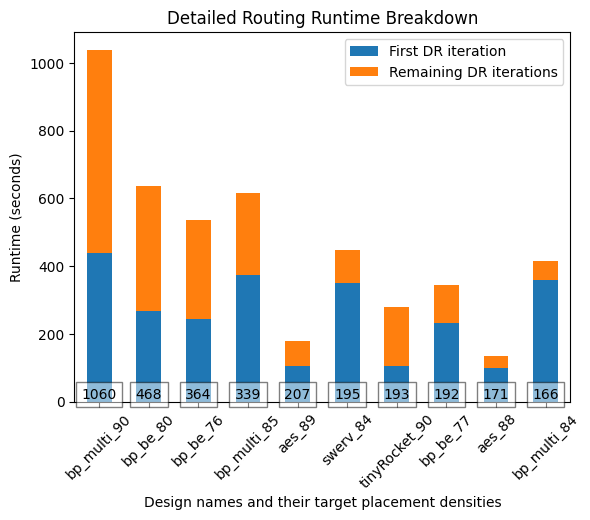

In [24]:
# Bar plot Routing Runtime Break Down
normalize = False
numCircuits = 10
dfRuntime = df[0:numCircuits].copy()
idx = [dfRuntime.loc[x, 'Design']+'_'+str(dfRuntime.loc[x, 'Density']) for x in range(numCircuits)]
dfRuntime['RuntimeDR'] = dfRuntime['RuntimeIDR'] + dfRuntime['RuntimeFDR']
dfRuntime['Benchmark'] = idx
dfRuntime = dfRuntime.set_index('Benchmark')



if normalize:
  dfRuntime['TotalRuntime'] = dfRuntime['RuntimeIDR']+dfRuntime['RuntimeFDR']
  dfRuntime['RuntimeIDR'] = dfRuntime['RuntimeIDR']/dfRuntime['TotalRuntime']
  dfRuntime['RuntimeFDR'] = dfRuntime['RuntimeFDR']/dfRuntime['TotalRuntime']

fig, ax = plt.subplots()
dfRuntime[['RuntimeIDR', 'RuntimeFDR']].plot(kind='bar', stacked=True, ax=ax)
drvs = dfRuntime['IDRVShort']

for i in range(numCircuits):
  bar = ax.patches[i]
  x = bar.get_x() + bar.get_width() / 2
  y = bar.get_height()
  # Place the text at the top of the bar segment
  ax.text(x, 0, f'{int(drvs[i])}', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5))

ylabel = "Normalized Runtime %" if normalize else "Runtime (seconds)"
ax.set_ylabel(ylabel)

ax.set_xlabel("Design names and their target placement densities")
plt.xticks(rotation=45)

if normalize:
  plt.ylim(top=ax.get_ylim()[1] * 1.14)
  plt.yticks([x*2/10 for x in range(6)], [x*20 for x in range(6)])

ax.set_title('Detailed Routing Runtime Breakdown')
ax.legend(['First DR iteration', 'Remaining DR iterations'], loc='upper right')
# plt.show()
name = "Norm" if normalize else ""
plt.savefig('3-RoutingRuntimeBreakdown'+name+'.pdf', bbox_inches="tight")

In [ ]:
runtimesStacked = {'Global Routing (max)':4.3,
                   'Global Routing (avg)':2.1,
                   'Detailed Routing (avg)':28.5,
                   'Detailed Routing (max)':96.4}
runtimes = runtimesStacked
runtimeDF = pd.DataFrame(runtimes, index=[0, 1])
runtimeDF.iloc[0] = [runtimes['Global Routing (max)'], runtimes['Global Routing (avg)'], 0, 0]
runtimeDF.iloc[1] = [0, 0, runtimes['Detailed Routing (avg)'], runtimes['Detailed Routing (max)']]


ax = runtimeDF.plot.bar(stacked=False, color=['#e06666ff', '#6C8EBF', '#82B366', '#9673A6'])
ax.set_ylabel("Runtime (hours)")
ax.set_xlabel("Routing Step")
ax.set_title('Routing Runtime of Industrial Designs')
ax.set_xticklabels(['Global Routing', 'Detailed Routing'], rotation=0)

plt.axhline(y=4.3, xmin=0.13, xmax=0.48, color='red', linestyle='--', linewidth=2)
plt.annotate('', (0.47, 4.3), (0.47, 96.4), arrowprops={'arrowstyle': '<-', 'linewidth': 1.5, 'color': 'red'})
plt.axhline(y=96.4, xmin=0.48, xmax=0.87, color='red', linestyle='--', linewidth=2)
plt.text(0.2, 50, '≈22.4×', fontsize=12, color='red')

plt.axhline(y=2.1, xmin=0.19, xmax=0.7, color='blue', linestyle='--', linewidth=2)
plt.annotate('', (0.9, 2.1), (0.9, 28.5), arrowprops={'arrowstyle': '<-', 'linewidth': 1.5, 'color': 'blue'})
plt.axhline(y=28.5, xmin=0.7, xmax=0.81, color='blue', linestyle='--', linewidth=2)
plt.text(0.62, 15, '≈13.5×', fontsize=12, color='blue')

plt.xlim(-0.5, 1.5)
plt.legend(loc='upper left')

plt.show()
# plt.savefig('RoutingRuntimeIndustrial.pdf')

# Other Ideas

In [ ]:
# Plot avg IDR short (considering full routed circuits only)
idrShort = []
for x in range(70, 91):
  tempDf = df.loc[df['Design'].str.contains(str(x))].copy()
  tempDf = tempDf.loc[tempDf['FDRTotal'] == 0]
  avgIDRShort = sum(tempDf['IDRShort']/len(tempDf))
  idrShort.append(avgIDRShort)
    
plt.plot([y for y in range(70, 91)], idrShort, color = 'r')
plt.xlabel("Design Density (Row Utilization %)")
plt.ylabel("Initial Detailed Routing Short Violations (IDRV)")
plt.title('Average IDR Short x Row Utilization (Only fully routable circuits)')

In [ ]:
# Plot avg IDR short (considering full routed circuits only)
fdrRuntime = []
for x in range(70, 91):
  tempDf = df.loc[df['Design'].str.contains(str(x))].copy()
  tempDf = tempDf.loc[tempDf['FDRTotal'] == 0]
  fdr = sum(tempDf['FDR']/len(tempDf))
  fdrRuntime.append(fdr)

plt.plot([y for y in range(70, 91)], fdrRuntime, color = 'r')
plt.xlabel("Design Density (Row Utilization %)")
plt.ylabel("Runtime (seconds)")
plt.title('Average Runtime to complete routing (Only fully routable circuits)')

# Related Works

In [ ]:
works = {
         '\cite{hung2023drc}':{'tp':683142, 'tn':51358028, 'fp':164763, 'fn':195806},# DRC Violation Prediction After Global Route_Through Convolutional Neural Network
         '\cite{tabrizi2019eh}':{'tp':4343, 'tn':225688, 'fp':10990, 'fn':102},# Eh? predictor: A deep learning framework to identify detailed routing short violations from a placed netlist
        }

# Transforming Global Routing Report into DRC Violation Map with Convolutional Neural Network
# DRC Violation Prediction with Pre-global-routing Features Through Convolutional Neural Network
# DRC Violation Prediction After Global Route Through Convolutional Neural Network

In [ ]:
work = works['\cite{hung2023drc}']
# work = works['\cite{tabrizi2019eh}']
print(getMetrics(work['tp'], work['tn'], work['fp'], work['fn']))
# Warning these results are not in percentage

In [ ]:
#Our ICECS
# Precision (PPV) and Recall (Sensitivity, TPR)
precision = 0.9799    # Replace with your actual precision
recall = 0.9316     # Replace with your actual recall

# Prevalence of Positive Class (Assuming you have this value)
prevalence_positive = 0.4 # Guess

# Calculate Prevalence of Negative Class
prevalence_negative = 1 - prevalence_positive

# Calculate Specificity (TNR)
specificity = (precision * prevalence_negative) / (precision * prevalence_negative + (1 - recall) * prevalence_positive)
gmean = math.sqrt(recall * specificity)
print('specificity',specificity,'sensitivity',recall,'gmean',gmean)

In [ ]:
# lin2023drc # DRC Violation Prediction with Pre-global-routing Features Through Convolutional Neural Network
# Positive Recall (TPR for the positive class) -> Recall/sensitivity
sensitivity = 0.7901
# Negative Recall (TNR for the negative class) -> Specificity
specificity = 0.9963
#TODO compute gmean
gmean = math.sqrt(sensitivity * specificity)
print('specificity',specificity,'sensitivity',sensitivity,'gmean',gmean)

In [ ]:
# soh vai faltar o J-Net (liang2020drc)

# Se achar que faltou algo adicionar:
# Transforming Global Routing Report into DRC Violation Map with Convolutional Neural Network

In [ ]:
# lin2023drc # DRC Violation Prediction with Pre-global-routing Features Through Convolutional Neural Network
total= 7146353
pos = 133251
prevalence = (pos/total)*100
prevalence

In [ ]:
# Ours total prevalence %
0.022565595314356077